In [34]:
import cv2
import numpy as np
import time
from scipy.optimize import least_squares
import math
import matplotlib.pyplot as plt
from utils import get_hsv_color_ranges
import os
import glob

In [35]:

def euclidean_distance(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

def ajustar_circulo(puntos):
    """
    Ajusta un círculo a los puntos dados
    """
    def residuo(params, puntos):
        cx, cy, r = params
        return [np.sqrt((x - cx)**2 + (y - cy)**2) - r for x, y in puntos]

    # Inicialización: Centro aproximado y radio promedio
    x_mean, y_mean = np.mean(puntos, axis=0)
    r_init = np.mean([np.sqrt((x - x_mean)**2 + (y - y_mean)**2) for x, y in puntos])
    params_iniciales = [x_mean, y_mean, r_init]

    # Ajustar el círculo
    resultado = least_squares(residuo, params_iniciales, args=(puntos,))
    cx, cy, r = resultado.x
    return cx, cy, r

def generar_puntos_circulo(cx, cy, r, n_puntos):
    """
    Genera n_puntos uniformemente distribuidos en el círculo ajustado
    """
    angulos = np.linspace(0, 2 * np.pi, n_puntos, endpoint=False)
    puntos_circulo = [(cx + r * np.sin(theta), cy - r * np.cos(theta)) for theta in angulos]
    return puntos_circulo

def calcular_semejanza(puntos_originales, puntos_circulo, radio):
    """
    Calcula la semejanza entre los puntos originales y los del círculo ajustado
    """
    #Calcular las distancias entre puntos originales y el más cercano de entre los puntos del círculo ajustado,
    #teniendo en cuenta que cada punto del círculo ajustado solo puede ser emparejado con dos puntos originales
    distancias = []
    puntos_disponibles = puntos_circulo.copy()
    puntos_unidos = {punto: [] for punto in puntos_circulo}
    for punto_orig in puntos_originales:
        distancias_punto = [euclidean_distance(punto_orig, punto_circulo) for punto_circulo in puntos_disponibles]
        distancia_minima = min(distancias_punto)
        distancias.append(distancia_minima)
        punto_cercano = puntos_disponibles[distancias_punto.index(distancia_minima)]
        puntos_unidos[punto_cercano].append(punto_orig)
        if len(puntos_unidos[punto_cercano]) == 2:
            puntos_disponibles.remove(punto_cercano)


    #Elevamos las distancias al cuadrado
    distancias = [distancia**3 for distancia in distancias]
    media_distancia = np.mean(distancias)
    desviacion_distancia = np.std(distancias)

    #Calculamos la semejanza
    semejanza = 1 / (1 + media_distancia/((radio**3)/200))

    return semejanza, puntos_unidos

def plot_circulo(puntos_originales, puntos_circulo, puntos_unidos):
    """
    Grafica los puntos originales y los del círculo ajustado
    """
    fig, ax = plt.subplots()

    # Graficar los puntos originales
    x_coords, y_coords = zip(*puntos_originales)
    ax.scatter(x_coords, y_coords, color='blue', label='Puntos originales')

    # Graficar los puntos del círculo ajustado
    x_coords, y_coords = zip(*puntos_circulo)
    ax.scatter(x_coords, y_coords, color='red', label='Puntos modelados')
    #ax.plot(x_coords + x_coords[:1], y_coords + y_coords[:1], color='red', label='Círculo ajustado')

    # Graficar la union entre cada punto original y su punto correspondiente en el círculo ajustado
    for punto_circulo, puntos_originales in puntos_unidos.items():
        for punto_orig in puntos_originales:
            x_coords, y_coords = zip(punto_circulo, punto_orig)
            ax.plot(x_coords, y_coords, color='green')

    # Configuración del gráfico
    ax.set_aspect('equal', adjustable='datalim')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Ajuste de círculo a los puntos')
    plt.grid()
    plt.show()

In [36]:
# Inicializar el filtro de Kalman
kalman = cv2.KalmanFilter(4, 2)
kalman.measurementMatrix = np.array([[1, 0, 0, 0],
                                      [0, 1, 0, 0]], np.float32)
kalman.transitionMatrix = np.array([[1, 0, 1, 0],
                                     [0, 1, 0, 1],
                                     [0, 0, 1, 0],
                                     [0, 0, 0, 1]], np.float32)
kalman.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03


def detect_bright_object(frame):
    """
    Detecta un objeto luminoso en la imagen y devuelve su posición
    """
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # Ajustar el rango para detectar brillo (alta saturación y valor)
    lower_bound = np.array([0, 0, 220], dtype=np.uint8)
    upper_bound = np.array([255, 15, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Encontrar contornos del objeto luminoso
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        if cv2.contourArea(largest_contour) > 50:  # Filtrar pequeños ruidos
            (x, y), _ = cv2.minEnclosingCircle(largest_contour)
            return int(x), int(y)
    return None

In [37]:
# # Find color range
# def load_images(filenames):
#     return [cv2.imread(filename) for filename in filenames]

# imgs_path = []
# current_directory = os.getcwd()
# parent_directory = os.path.dirname(current_directory)
# folder = os.path.join(parent_directory, "data")
# folder = folder.replace("\\", "/") + "/"
# print(folder)
# for filename in glob.glob(folder + "*.jpg"):
#     imgs_path.append(filename)
# imgs = load_images(imgs_path)

# # TODO Get a list with ìmgs in HSV color space
# hsv_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2HSV) for img in imgs]

# # TODO Complete the method, use every argument
# def show_image(img: np.array, img_name: str = "Image"):
#     cv2.imshow(img_name, img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

# def nothing(x):
#     pass

# def get_hsv_color_ranges(image: np.array):
#     # Scale the image to fit into a specific window size while maintaining aspect ratio
#     def scale_image(img, max_width=1280, max_height=720):
#         height, width = img.shape[:2]
#         scale = min(max_width / width, max_height / height)
#         if scale < 1:
#             img = cv2.resize(img, (int(width * scale), int(height * scale)))
#         return img

#     # Rescale the input image
#     resized_image = scale_image(image)

#     # Create separate windows for the image and trackbars
#     cv2.namedWindow('image', cv2.WINDOW_NORMAL)
#     cv2.resizeWindow('image', 1280, 720)
#     cv2.namedWindow('Trackbars', cv2.WINDOW_NORMAL)
#     cv2.resizeWindow('Trackbars', 500, 200)

#     # Create trackbars for HSV ranges in the Trackbars window
#     cv2.createTrackbar('HMin', 'Trackbars', 0, 255, nothing)
#     cv2.createTrackbar('SMin', 'Trackbars', 0, 255, nothing)
#     cv2.createTrackbar('VMin', 'Trackbars', 0, 255, nothing)
#     cv2.createTrackbar('HMax', 'Trackbars', 0, 255, nothing)
#     cv2.createTrackbar('SMax', 'Trackbars', 0, 255, nothing)
#     cv2.createTrackbar('VMax', 'Trackbars', 0, 255, nothing)

#     # Set default values for MAX HSV trackbars
#     cv2.setTrackbarPos('HMax', 'Trackbars', 255)
#     cv2.setTrackbarPos('SMax', 'Trackbars', 255)
#     cv2.setTrackbarPos('VMax', 'Trackbars', 255)

#     # Initialize previous HSV values for tracking changes
#     phMin = psMin = pvMin = phMax = psMax = pvMax = -1
#     wait_time = 33

#     while True:
#         # Get current trackbar positions
#         hMin = cv2.getTrackbarPos('HMin', 'Trackbars')
#         sMin = cv2.getTrackbarPos('SMin', 'Trackbars')
#         vMin = cv2.getTrackbarPos('VMin', 'Trackbars')
#         hMax = cv2.getTrackbarPos('HMax', 'Trackbars')
#         sMax = cv2.getTrackbarPos('SMax', 'Trackbars')
#         vMax = cv2.getTrackbarPos('VMax', 'Trackbars')

#         # Set HSV ranges
#         lower = np.array([hMin, sMin, vMin])
#         upper = np.array([hMax, sMax, vMax])

#         # Convert to HSV and mask
#         hsv = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)
#         mask = cv2.inRange(hsv, lower, upper)
#         output = cv2.bitwise_and(resized_image, resized_image, mask=mask)

#         # Print HSV changes
#         if (hMin != phMin) or (sMin != psMin) or (vMin != pvMin) or \
#            (hMax != phMax) or (sMax != psMax) or (vMax != pvMax):
#             print(f"(hMin = {hMin}, sMin = {sMin}, vMin = {vMin}), "
#                   f"(hMax = {hMax}, sMax = {sMax}, vMax = {vMax})")
#             phMin, psMin, pvMin, phMax, psMax, pvMax = hMin, sMin, vMin, hMax, sMax, vMax

#         # Display the processed image
#         cv2.imshow('image', output)

#         # Break on 'q'
#         if cv2.waitKey(wait_time) & 0xFF == ord('q'):
#             break

#     cv2.destroyAllWindows()

# get_hsv_color_ranges(imgs[0])

Semejanza: 0.18502487123107225


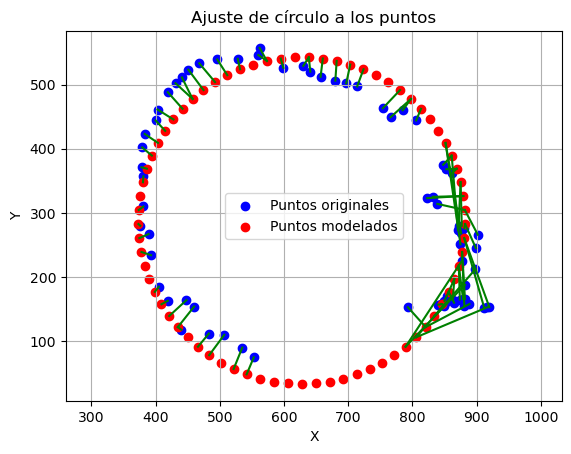

In [ ]:
# Captura de video desde la cámara
cap = cv2.VideoCapture(0)

# Set the dimensions
frame_width = 1280
frame_height = 720
cap.set(cv2.CAP_PROP_FRAME_WIDTH, frame_width)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_height)

tracking_positions = []
tracking_started = False
start_time = None
initial_position = None

# Mostrar cuenta atrás antes de iniciar el seguimiento
for i in range(3, 0, -1):
    for j in range(10):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.flip(frame, 1)  # Invertir la imagen
        cv2.putText(frame, f"Comienza en {i}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        cv2.imshow('Seguimiento de Luz', frame)
        cv2.waitKey(100)

# Initialize variables for displaying the similarity score
show_similarity_score = False
similarity_score = None
score_display_start_time = None

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.flip(frame, 1)

    # Display similarity score if available and within the display duration
    if show_similarity_score:
        elapsed_display_time = time.time() - score_display_start_time
        elapsed_time = 0
        if elapsed_display_time < 5:
            cv2.putText(frame, f"Semejanza: {similarity_score:.2f}", (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        else:
            show_similarity_score = False
            break
    else:
        # Main tracking logic
        detected = detect_bright_object(frame)
        if detected:
            measured = np.array([[np.float32(detected[0])], [np.float32(detected[1])]])
            kalman.correct(measured)

            if not tracking_started:
                tracking_started = True
                start_time = time.time()
                initial_position = detected

        # Kalman prediction and tracking visualization
        predicted = kalman.predict()
        predicted_x, predicted_y = int(predicted[0].item()), int(predicted[1].item())

        if detected:
            cv2.circle(frame, detected, 10, (0, 255, 0), 2)
            if tracking_started:
                tracking_positions.append(detected)

        for i in range(1, len(tracking_positions)):
            cv2.line(frame, tracking_positions[i - 1], tracking_positions[i], (0, 0, 255), 2)

        cv2.circle(frame, (predicted_x, predicted_y), 10, (255, 0, 0), 2)
        # Show elapsed time
        elapsed_time = time.time() - start_time if tracking_started else 0
        cv2.putText(frame, f"Tiempo transcurrido: {elapsed_time:.2f} s", (50, 100),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

    # Check for circle similarity once tracking completes
    if tracking_started and elapsed_time > 1:
        if elapsed_time > 6:
            print("Demasiado lento")
            break
        if detected and initial_position and euclidean_distance(detected, initial_position) < 40:
            if elapsed_time < 2:
                print("Demasiado rápido")
                break

            # Process tracking positions
            tracking_positions = [tracking_positions[i] for i in range(len(tracking_positions))
                                  if i == 0 or euclidean_distance(tracking_positions[i], tracking_positions[i - 1]) > 3]

            circulo = ajustar_circulo(tracking_positions)
            if circulo[2] < 125:
                print("Círculo demasiado pequeño")
                break
            else:
                if not show_similarity_score:
                    puntos_circulo = generar_puntos_circulo(circulo[0], circulo[1], circulo[2], len(tracking_positions))
                    semejanza, puntos_unidos = calcular_semejanza(tracking_positions, puntos_circulo, circulo[2])
                    print("Semejanza:", semejanza)

                    # Activate similarity score display
                    similarity_score = semejanza
                    show_similarity_score = True
                    score_display_start_time = time.time()

    # Display the current frame
    cv2.imshow('Seguimiento de Luz', frame)

    # Exit condition
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

plot_circulo(tracking_positions, puntos_circulo, puntos_unidos)